In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import librosa
import pickle
%matplotlib inline

In [8]:
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from livelossplot import PlotLossesKeras

In [4]:
%run ../Utilities/Utilities.ipynb

In [56]:
data = pd.read_pickle("../Data/Guitar/bpm-data.pkl")

In [57]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, "bpm")

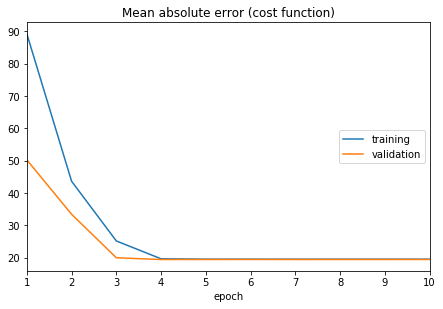

Mean absolute error (cost function):
training   (min:   19.574, max:   89.256, cur:   19.574)
validation (min:   19.469, max:   50.277, cur:   19.480)


In [58]:
inputs = Input(shape=(8,))
hidden1 = Dense(16, activation="relu")(inputs)
preds = Dense(1)(hidden1)

model = Model(inputs=inputs, outputs=preds)
sgd = keras.optimizers.Adam(lr=0.0005)
model.compile(optimizer=sgd, loss='mean_absolute_error')
history = model.fit(X_train, y_train, batch_size=None, epochs=10, verbose=0,
                    validation_data=(X_val, y_val),
                    callbacks=[PlotLossesKeras()])

In [59]:
model.predict(pd.DataFrame({
    "d0": [0.475],
    "d1": [0.28125],
    "d2": [0.5125],
    "d3": [0.21875],
    "d4": [0.28125],
    "d5": [0.275],
    "d6": [0.45625],
    "d7": [0.15625]
}))

array([[129.2044]], dtype=float32)